In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
%%time

tweets_df = pd.read_json('../input/iphone-11-tweets-fr.json', lines=True)
tweets_df.head(3)

CPU times: user 4.28 s, sys: 740 ms, total: 5.02 s
Wall time: 9.97 s


,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/DLessay/status/13450795319...,2021-01-01 18:48:45+00:00,@MartinFayulu Vieux na iphone 11 pona image ya...,@MartinFayulu Vieux na iphone 11 pona image ya...,1345079531917471749,"{'username': 'DLessay', 'displayname': 'anthon...",[],[],0,0,...,0,1345040117300387841,fr,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,NaN,None,"[{'username': 'MartinFayulu', 'displayname': '..."
1,https://twitter.com/amelwltr/status/1345076458...,2021-01-01 18:36:32+00:00,c bon j'ai commandé l'iphone 11 🥵,c bon j'ai commandé l'iphone 11 🥵,1345076458105016321,"{'username': 'amelwltr', 'displayname': 'amel'...",[],[],0,0,...,0,1345076458105016321,fr,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,None,None
2,https://twitter.com/enbrrrr_/status/1345076206...,2021-01-01 18:35:32+00:00,"Eh les amis, je souhaite un iphone 11 merci, c...","Eh les amis, je souhaite un iphone 11 merci, c...",1345076206383857664,"{'username': 'enbrrrr_', 'displayname': '𝑲𝒖𝒓𝒂𝒎...",[],[],0,0,...,0,1345076206383857664,fr,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,None,None


In [3]:
cols = ['date', 'content', 'lang']
tweets_df = tweets_df[cols]

tweets_df = tweets_df[tweets_df['lang'] == 'fr']

tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

tweets_df = tweets_df.sort_values("content") 
tweets_df = tweets_df.drop_duplicates(subset ="content", keep = 'first')

In [4]:
# cette liste a été générée avec https://www.tagsfinder.com/

ads_words = ['#concours', '#giveaway', '#jeuconcours', '#france', '#paris', '#concoursinstagram', '#contest',
             '#love', '#cadeau',
            '#jeu', '#photography', '#fashion', '#beauty', '#instagood', '#picoftheday', '#makeup', 
            '#mode', '#lifestyle', '#fitness', '#jeuxconcours', '#repost', '#noel', '#instaconcours', '#girl', 
            '#calendrierdelavent', '#bijoux', '#blogger', '#photo', '#instagram', '#gift',
            'concours', 'jeuconcours', 'giveaway',
            '#gagne' ,'#gangner', 'promo', 'promotion', 'publicité',
            'contest', '#ad', '#pub', '#réduction', 'actualité', '#actualité']

tweets_df = tweets_df[~tweets_df['content'].str.contains('|'.join(ads_words), case=False)]

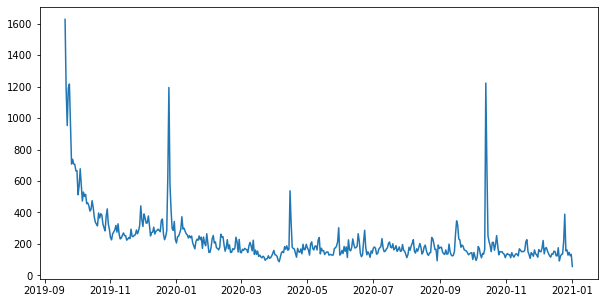

In [5]:
tweets_df['date'].value_counts().plot(kind='line', figsize=(10, 5))

plt.show()

In [6]:
import re
import spacy
from gensim.utils import tokenize

import json

from io import StringIO
from html.parser import HTMLParser

from collections import Counter 

In [7]:
# fonction pour supprimer les symbols HTML

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    '''
    input, output: string
    '''
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [8]:
# remplacement des abréviations

with open('../input/abrivot_fr.json', encoding='utf-8') as f:
    abrivot = json.load(f)
    
def replace_abrivot(text):
    '''
    input: string
    output: list of tokens
    '''
    words = text.split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

In [9]:
# lemmatization fonction
# Verbs are missleading
# si ça marche pas
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])


def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    '''
    input: string
    output: list of tokens
    '''
    doc = nlp(text) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_alpha]
    return text_out

In [10]:
# fonction générale pour le prétraitement

def tweets_preprocesser(tweets):
    all_tweets=[]
    for tweet in tweets:
        
        # supprimer les symboles HTML
        reformed = strip_tags(tweet)
        
        # supprimer les urls et les @mentions
        reformed = re.sub(r'(?:\@|https?\://)\S+', '', reformed)
        
        # remplacer les abréviations
        reformed = replace_abrivot(reformed)
        
        # lemmatization
        tokens = lemmatization(reformed)
        
        tweet_cleaned = " ".join(tokens)
        all_tweets.append(tweet_cleaned)
    all_text = ' '.join(all_tweets)
    all_words = all_text.split()
    return all_tweets, all_words

In [11]:
%%time
all_tweets, all_words = tweets_preprocesser(tweets_df['content'])

CPU times: user 4min 57s, sys: 242 ms, total: 4min 58s
Wall time: 4min 58s


In [12]:
# préparer la liste des mots vide, 626 mots
# importer les mots vides de la langue Française

stop_words = nlp.Defaults.stop_words

# fonction pour séléctionner les n mots le plus pertinants
# pour les rajouter dans la liste des mots vides

def select_top_words(bag_words, n_words=30):
    
    # Count all the words using Counter Method
    count_words = Counter(all_words)
    total_words=len(all_words)
    sorted_words=count_words.most_common(total_words)
    
    # select the n_words top words
    top_words = [word[0] for word in sorted_words[:n_words]]
    return top_words

# mettre à jour la liste des mots vides avec les 30 mots les plus fréquents
stop_words.update(select_top_words(all_words))

In [13]:
# supprimer les mots vides
def remove_stopwords(texts):
    
    tokens = [[word for word in doc.split() if word not in stop_words] for doc in texts]
    all_tweets = [' '.join(doc) for doc in tokens if len(doc) > 1]
    #all_words = (' '.join(all_tweets)).split()
    
    return all_tweets#, all_words

all_tweets = remove_stopwords(all_tweets)

In [14]:
all_tweets[:10]

['test smartphone intéressant xr',
 'test minimum effort',
 'meuf fric voiture l vite corde acide eau javel vite',
 'étai chéri bombe',
 'parent abruti deg énorme sérieux',
 'manon mère anniversaire an',
 'bol précarité message',
 'way future propriétaire miroir ici',
 'blanc noir putain',
 'sûr chargeur']

CPU times: user 2.29 s, sys: 40 ms, total: 2.33 s
Wall time: 2.43 s


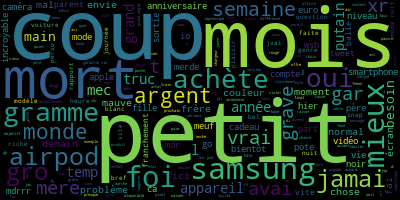

In [15]:
%%time

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ' '.join(all_tweets)

# Create a WordCloud object
wordcloud = WordCloud()

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()